In [44]:
# fmt: off
import cirq
import stim
import numpy as np
from typing import Literal
import matplotlib.pyplot as plt

from bloqade import squin
from bloqade.squin import kernel
from bloqade.tsim import Circuit
import bloqade.cirq_utils as utils

import numpy as np



In [46]:
def make_magic_steane_encoding_kernel(n_rounds: int, basis: str, inject_magic: bool):
    """
    Builds a Steane-code magic state encoding and verification circuit.

    Args:
        n_rounds (int): Number of encoding rounds.
        basis (str): Measurement basis for logical checks ('X' or 'Y').
        inject_magic (bool): Whether to inject a T|+> magic state.
    """

    @kernel
    def steane_encode_block(block):
        """
        Encodes a 17-qubit block using the Steane-style encoding circuit.
        """
        for _ in range(n_rounds):

            # --- Layer 1: Basis rotations ---
            squin.broadcast.sqrt_y(block[:7])
            squin.broadcast.sqrt_y(block[8:17])

            # --- Layer 2: Steane stabilizer entanglement ---
            squin.broadcast.cz(
                [block[1], block[7], block[12], block[13]], 
                [block[3], block[10], block[14], block[16]]
            )

            squin.broadcast.sqrt_y_adj([block[7], block[16]])

            # --- Layer 3 ---
            squin.broadcast.cz(
                [block[4], block[8], block[11], block[15]], 
                [block[7], block[10], block[14], block[16]]
            )

            squin.broadcast.sqrt_y_adj([block[4], block[10], block[14], block[16]])

            # --- Layer 4 ---
            squin.broadcast.cz(
                [block[2], block[6], block[7], block[10], block[14]], 
                [block[4], block[8], block[9], block[13], block[16]]
            )

            squin.broadcast.sqrt_y(
                [block[3], block[6], block[9], block[10], block[12], block[13]]
            )

            # --- Layer 5 ---
            squin.broadcast.cz(
                [block[0], block[3], block[5], block[10], block[11]], 
                [block[2], block[6], block[8], block[12], block[13]]
            )

            squin.broadcast.sqrt_y(
                [block[1], block[2], block[3], block[4], block[6], block[7],
                 block[8], block[9], block[11], block[12], block[14]]
            )

            # --- Layer 6 ---
            squin.broadcast.cz(
                [block[0], block[2], block[4], block[6], block[8], block[12]], 
                [block[1], block[3], block[5], block[7], block[9], block[15]]
            )

            squin.broadcast.sqrt_y_adj(
                [block[0], block[2], block[5], block[6],
                 block[8], block[10], block[12]]
            )


    @kernel
    def measure_logical_checks(block):
        """
        Measures logical observative in the chosen basis.
        """
        targets = [block[1], block[3], block[10], block[12], block[15]]

        if basis == 'X':
            squin.broadcast.h(targets)
        elif basis == 'Y':
            squin.broadcast.s_adj(targets)
            squin.broadcast.h(targets)

        squin.broadcast.measure(targets)


    @kernel
    def measure_block(block):
        """Measures an entire encoded block in the Z basis."""
        squin.broadcast.measure(block)


    @kernel
    def circuit():
        """
        Full magic-state Steane encoding circuit.
        """
        # Data block (magic or |0>)
        data_block = squin.qalloc(17)

        if inject_magic:
            squin.broadcast.h(data_block[7])
            squin.broadcast.t(data_block[7])

        # Reference blocks
        plus_block = squin.qalloc(17)
        zero_block = squin.qalloc(17)

        # Prepare logical |+>
        squin.broadcast.h(plus_block[7])

        # Encode all blocks
        steane_encode_block(data_block)
        steane_encode_block(plus_block)
        steane_encode_block(zero_block)

        # Transversal Steane parity checks
        squin.broadcast.cx(data_block, plus_block)
        squin.broadcast.cx(zero_block, data_block)

        # Measure syndromes
        measure_logical_checks(data_block)
        measure_block(plus_block)

        # Measure zero block in X basis
        squin.broadcast.h(zero_block)
        measure_block(zero_block)

    return circuit

# Example Circuit
kernel = make_magic_steane_encoding_kernel(1,'Z',False)
c = Circuit(kernel)

c.diagram(height=540)

In [47]:
def embed_mover_noise(k, noise_param, dnoise):
    """
    Apply Gemini noise to a Squin kernel.
    """
    # Convert Squin kernel to Cirq circuit
    cirq_circuit = utils.emit_circuit(k)

    # Set default noise for each parameter
    default_noises = {param: dnoise for param in noise_param}

    # Initialize Gemini noise model
    noise_model = utils.noise.GeminiOneZoneNoiseModel(**default_noises)

    # Apply noise and convert to native gates, parallelizing if possible
    noisy_cirq_circuit = utils.noise.transform_circuit(
        cirq_circuit, to_native_gateset=True, model=noise_model, parallelize_circuit=True
    )

    # Load back into Squin
    squin_circuit = utils.load_circuit(noisy_cirq_circuit, kernel_name="main_loaded")

    return squin_circuit


In [4]:
def eigen_calc(arr):
    eigenvalues = np.where(arr == 0, 1, -1)   
    return eigenvalues 

def eigen_calc_prod(arr):
    eigenvalues = eigen_calc(arr)
    logical_eigen = np.prod(eigenvalues, axis=1) 
    logical_bit = np.where(logical_eigen == 1, 0, 1)

    return logical_bit

In [48]:
import numpy as np
# Stabilizer supports (faces) for Steane code
FACES = [
    [0, 1, 2, 3],
    [0, 2, 4, 5],
    [4, 5, 6, 7],
    [6, 7, 8, 9],
    [2, 3, 5, 6, 8, 10, 11, 13],
    [11, 13, 14, 16],
    [10, 11, 12, 14],
    [12, 14, 15, 16]
]

def get_bit_and_stabilizers(kernel):
    """
    Run the kernel and extract logical bit and stabilizer measurement outcomes.
    """
    # Sample measurements from the kernel
    samples = kernel.compile_sampler(seed=0).sample(shots=5000, batch_size=10000)

    # Split raw measurement samples into logical qubits and stabilizer blocks
    logical_combination = samples[:, :5]       # logical qubits
    plus_syndromes = samples[:, 5:22]         # |+> block stabilizers
    zero_syndromes = samples[:, 22:39]        # |0> block stabilizers

    # Compute logical outcomes from stabilizers
    logical_bit = eigen_calc_prod(logical_combination)

    # Compute plus block stabilizers
    plus_stabilizers = np.stack(
        [eigen_calc_prod(plus_syndromes[:, face]) for face in FACES], axis=1
    )

    # Compute zero block stabilizers
    zero_stabilizers = np.stack(
        [eigen_calc_prod(zero_syndromes[:, face]) for face in FACES], axis=1
    )

    # Combine X- and Z-type stabilizers
    stabilizers = np.concatenate([plus_stabilizers, zero_stabilizers], axis=1)

    return logical_bit, stabilizers

def build_and_run(basis, noise_params, dnoise, magic):
    """
    Build Steane kernel, apply noise, run, and extract postselected logical expectation.
    """
    # Build Steane kernel
    steane_kernel = make_logical_distillation_kernel(
        p=0.01, n_iterations=1, basis=basis, magic=magic
    )

    # Apply Gemini hardware noise
    noisy_kernel = embed_mover_noise(steane_kernel, noise_params, dnoise)
    circuit = Circuit(noisy_kernel)

    # Extract logical measurement outcomes and stabilizers
    logical_bit, stabilizers = get_bit_and_stabilizers(circuit)
    total_shots = len(logical_bit)

    # Postselect on trivial Steane syndrome
    postselect_mask = np.all(
        stabilizers == np.array([0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0]), axis=1
    )
    logical_bit = logical_bit[postselect_mask]

    # Compute expectation value ⟨σ_basis⟩
    p1 = np.count_nonzero(logical_bit) / len(logical_bit)
    expectation = 1 - 2 * p1  # maps 0->1, 1->-1

    return expectation, len(logical_bit) / total_shots

def get_fidelity(psi, noise_params, dnoise, magic):
    """
    Compute fidelity of a logical qubit encoded with Steane code under noise.
    """
    # Logical Pauli expectations
    vx, _ = build_and_run('X', noise_params, dnoise, magic)
    vy, _ = build_and_run('Y', noise_params, dnoise, magic)
    vz, postselected_fraction = build_and_run('Z', noise_params, dnoise, magic)

    # Pauli matrices
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])

    # Logical density matrix ρ = 1/2 * (I + vx X + vy Y + vz Z)
    rho = (I + vx*X + vy*Y + vz*Z) / 2

    # Fidelity F = ⟨ψ|ρ|ψ⟩
    fidelity = psi.conj().T @ rho @ psi

    return fidelity.real, postselected_fraction


In [49]:
def sweep_fidelities(psi,noise_params,noises,magic):
    fidelities = []
    for dnoise in noises:
        try:
            fidelities.append(get_fidelity(psi,noise_params,dnoise,magic))
        except Exception as e:
            print(dnoise)
            break
    
    return np.array(fidelities)

def sweep_logical_errors(psi,noise_params,noises):
    logical_errors = []
    for dnoise in noises:
        logical_errors.append(get_fidelity(psi,noise_params,dnoise)[1])
    
    return logical_errors

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fidelity(parameters):
    noises = np.linspace(0.1, 2.0, 15)
    
    for i, param_set in enumerate(parameters):
        plt.figure(figsize=(8, 6))
        
        # Non-magic state |0>
        psi_zero = np.array([1, 0])
        fidelities_no_magic = sweep_fidelities(psi_zero, param_set, noises, magic=False)
        plt.plot(fidelities_no_magic[:,1], fidelities_no_magic[:,0], label="No Magic", linestyle='-', marker='o')
        
        # Magic T state
        psi_T = np.array([1, np.exp(1j * np.pi / 4)]) / np.sqrt(2)
        fidelities_magic = sweep_fidelities(psi_T, param_set, noises, magic=True)

        plt.plot(fidelities_magic[:,1], fidelities_magic[:,0], label="Magic T State", linestyle='--', marker='s')
        
        
        plt.ylabel("Fidelity")
        plt.xlabel("Selected Fraction")
        plt.title(f"Post Selection Effects on Fidelity")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

2.0


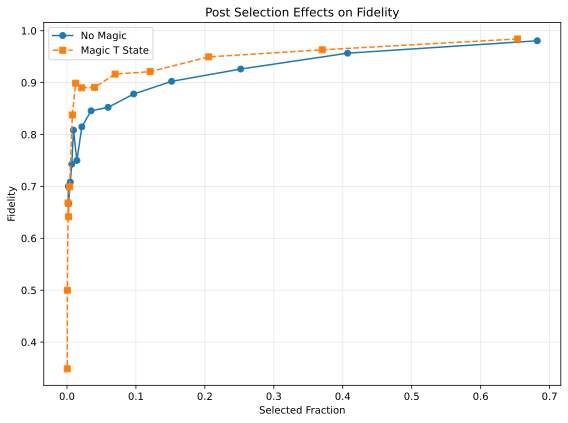

In [18]:
plot_fidelity([["scaling_factor"]])